In [1]:
import os, tqdm, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re
%matplotlib inline

# Code to generate data

In [2]:
df = pd.read_parquet("/glade/campaign/cisl/aiml/ai2es/winter_ptypes/models/evidential_unweighted/evaluate/test_0.parquet")
df_det = pd.read_parquet("/glade/campaign/cisl/aiml/ai2es/winter_ptypes/models/classifier_unweighted/evaluate/test_0.parquet")

#df = pd.read_parquet("/glade/work/schreck/repos/apr24/results/ptype/weighted/evidential/evaluate/test_7.parquet")
#df_det = pd.read_parquet("/glade/scratch/schreck/repos/evidential/results/ptype/weighted/classifier/evaluate/test_7.parquet")

In [3]:
true_labels = df["true_label"].values
pred_labels = df["pred_label"]
pred_probs = df[[f"pred_conf{k+1}" for k in range(4)]].values
confidences = df["pred_conf"]

evidential = df["evidential"]
total = np.sqrt(df["epistemic"] + df["aleatoric"])
epistemic = np.sqrt(df["epistemic"])
aleatoric = np.sqrt(df["aleatoric"])

df["total"] = total

In [4]:
n_splits = 10

ensemble_p = np.zeros((n_splits, df_det.shape[0]))
ensemble_std = np.zeros((n_splits, df_det.shape[0]))
ensemble_entropy = np.zeros((n_splits, df_det.shape[0]))
ensemble_mutual = np.zeros((n_splits, df_det.shape[0]))

# Loop over ensemble of parametric models
for split in tqdm.tqdm(range(n_splits)):
    dfe = pd.read_parquet(os.path.join("/glade/campaign/cisl/aiml/ai2es/winter_ptypes/models/classifier_unweighted/", "evaluate", f"test_{split}.parquet"))
    ensemble_p[split] = dfe["pred_conf"]
    ensemble_std[split] = dfe["pred_conf"] * (1 - dfe["pred_conf"])
    ensemble_entropy[split] = dfe["entropy"]
    ensemble_mutual[split] = dfe["mutual_info"]

# Compute averages, uncertainties 
df_det["ave_conf"] = np.mean(ensemble_p, axis = 0)
df_det["ave_entropy"] = np.mean(ensemble_entropy, axis = 0)
df_det["ave_mutual_info"] = np.mean(ensemble_mutual, axis = 0)
df_det["epistemic"] = np.var(ensemble_p, axis = 0)
df_det["aleatoric"] = np.mean(ensemble_std, axis = 0)
df_det["total"] = df_det["epistemic"] + df_det["aleatoric"]

df_det["epistemic"] = np.sqrt(df_det["epistemic"])
df_det["aleatoric"] = np.sqrt(df_det["aleatoric"])
df_det["total"] = np.sqrt(df_det["total"])

100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


# Plotting Code

In [5]:
UNCERT_TYPE='epistemic'
PROFILE_VAR='TEMP_C'

In [13]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from metpy.plots import SkewT
from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units

import os
import time

COLOR_DICT = {"t_h": "r", "dpt_h": "b", "wb_h": "c"}


def skewCompositeFigAx(figsize=(5, 5), num_subplots=1, rows=1, cols=None):
    # fig ax setup for skewx fig
    # returns top subfigure and a list of axs lists

    if (num_subplots > 1) and (figsize == (5, 5)):
        figsize = (10, 5)
    if cols:  # add blank subplots below
        num_subplots = cols

    fig = plt.figure(figsize=figsize)
    sfigs = fig.subfigures(rows, 1)
    if rows == 1:
        sfigs = [sfigs]

    skew_axs = sfigs[0].subplots(
        1, num_subplots, sharey=True, subplot_kw=dict(projection="skewx", rotation=30)
    )
    if num_subplots==1:
        skew_axs = [skew_axs]

    axs = skew_axs
    if num_subplots == 1:
        axs = [axs]
    if rows > 1:
        t_axs = sfigs[1].subplots(1, num_subplots, sharex=True)
        axs = [skew_axs, t_axs]

    skew_axs[0].set_ylabel("Height above ground (m)", fontsize=14)
    for ax in skew_axs:
        ax.grid(which="both")

        major_ticks = np.arange(-100, 100, 5)
        ax.set_xticks(major_ticks)
        ax.grid(which="major", alpha=0.5)

        # minor_ticks = np.arange(xlowlim - 60, xhighlim, 1)
        # ax.set_xticks(minor_ticks, minor=True)
        # ax.grid(which='minor', alpha=0.2)

        ax.axvline(x=0, ymin=0, ymax=1, c="0")
        ax.set_ylim(-100, 5100)
        ax.set_xlim(-15, 30)
    if rows == 1:
        axs = skew_axs
    return sfigs[0], axs


########### data processing ###############

BBOX = {
    "lon_min": 225.90453,
    "lon_max": 299.0828,
    "lat_min": 21.138123,
    "lat_max": 52.615654,
}


def filter_latlon(ds):
    mask = (
        (ds.latitude <= BBOX["lat_max"])
        & (ds.latitude >= BBOX["lat_min"])
        & (ds.longitude <= BBOX["lon_max"])
        & (ds.longitude >= BBOX["lon_min"])
    )
    return ds.where(mask.compute(), drop=True)


def wb_stull(ds):
    # wrf.wetbulb is super slow because of calls to fortran
    # this fn uses stulls method

    rh_h = relative_humidity_from_dewpoint(ds.t_h * units.degC, ds.dpt_h * units.degC)
    rh_h = rh_h.metpy.magnitude * 100
    T = ds.t_h
    ds["wb_h"] = (
        T * np.arctan(0.151977 * np.sqrt(rh_h + 8.313659))
        + np.arctan(T + rh_h)
        - np.arctan(rh_h - 1.676331)
        + 0.00391838 * np.power(rh_h, 3 / 2) * np.arctan(0.023101 * rh_h)
        - 4.686035
    )
    return ds


def frac_abv_zero(ds, x_col, total):
    num_over_zero = (ds[x_col] > 0).any(dim="heightAboveGround").sum()
    return num_over_zero / total


def frac_abv_split_time(ds, x_cols):
    np.seterr(divide="ignore", invalid="ignore")
    ds = ds[x_cols]
    num_over_zero = (ds > 0).any(dim="heightAboveGround").sum(dim=("x", "y"))
    obs = (
        ds[x_cols[0]]
        .isel(heightAboveGround=0)
        .count(dim=("x", "y"))
        .drop_vars("heightAboveGround")
    )

    # if ((obs == 0).sum().values > 0) or (obs.isnull().sum().values > 0):
    #    print(f'Warning: obs has a 0 val ({ds["time"]}, {ds.case_study_day})')

    return num_over_zero / obs


########### data analysis ###############


def count_nulls(ds):
    nulls = ds.isnull().sum()
    for var in list(nulls.keys()):
        print(f"{var}: {nulls[var].values}")


def count_notnulls(ds):
    notnulls = ds.notnull().sum()

    for var in list(notnulls.keys()):
        print(f"{var}: {notnulls[var].values}")


def timer(tic, message=""):
    toc = time.time()
    duration = toc - tic
    minutes = int(duration / 60)
    print(
        f"{message}. Elapsed time: {str(minutes) + ' minutes, ' if minutes else ''}{int(duration % 60)} seconds"
    )


def fn_timer(fn):
    tic = time.time()

    out = fn()

    toc = time.time()
    duration = toc - tic
    minutes = int(duration / 60)
    print(
        f"Elapsed time: {str(minutes) + ' minutes, ' if minutes else ''}{int(duration % 60)} seconds"
    )
    return out


def open_ds_dkimpara(
    hour, model, cluster="casper", concat_dim="valid_time", parallel=False
):
    if "glade" in os.getcwd():
        if cluster != "casper":
            filepath = (
                f"""/glade/scratch/dkimpara/ptype_case_studies/"""
                f"""kentucky/{model}/20220223/{hour}/*.nc"""
            )
        else:
            filepath = (
                f"""/glade/campaign/cisl/aiml/ptype/ptype_case_studies/"""
                f"""kentucky/{model}/20220223/{hour}/*.nc"""
            )

        ds = xr.open_mfdataset(
            filepath, concat_dim=concat_dim, combine="nested", parallel=parallel
        )
    else:  # running locally
        ds = xr.open_mfdataset(
            f"""/Users/dkimpara/gh/ptype-data/{model}/{hour}/*.nc""",
            concat_dim=concat_dim,
            combine="nested",
        )
    ds.attrs["nwp"] = model

    # todo: filter latlon

    # if "wb_h" not in list(ds.keys()):
    #    ds = wet_bulb_from_rel_humid(ds)
    return ds

In [11]:
def extract_cols(df, plot_cols='TEMP_C'):
    all_cols = list(df.columns)
    data_cols = []
    for col in all_cols:
        if plot_cols in col: data_cols.append(col)
    return df[data_cols], data_cols

ptype_dict = {0: 'Rain',
      1: 'Snow',
      2: 'Sleet',
      3: 'Frz Rain'}

color_dict = {0: 'm',
              1: 'b',
              2: 'y',
              3: 'c'}

color_to_ptype = {color: ptype_dict[num] for num, color in color_dict.items()}

def plot_(fig, ax, df, uncert_percentile, plot_below_percentile=True, title='',
         uncert_type=UNCERT_TYPE, profile_var=PROFILE_VAR, plot_kwargs={}):
    #plot all ptypes on same graph
    for ptype in range(4):
        subdf = df[(df.pred_label == ptype)]
        top_quantile = subdf[uncert_type].quantile(q=uncert_percentile)
        
        if plot_below_percentile:
            subdf = subdf[subdf[uncert_type] <= top_quantile]
        else:
            subdf = subdf[subdf[uncert_type] >= top_quantile]

        plot_data, data_cols = extract_cols(subdf)
        profile = plot_data.median()
        heights = [int(re.findall("(\d+)",txt)[0]) for txt in data_cols]

        (line,) = ax.plot(profile, heights, color_dict[ptype], linewidth=2, **plot_kwargs)
        
        line.set_label(
            (
                f'{ptype_dict[ptype]}'
            )
        )
    ax.set_xlabel(f'{profile_var}')
    ax.legend()
    ax.set_title(title)
    return fig, ax

# top 10% left
# bottom 10% right
# top 10 probability plots

# Plot all uncertainty levels on one figure for each model by varying alpha

In [17]:
def plot_many_uncerts(fig, ax, df, levels, alpha, plot_below_percentile=True, title='',
                     uncert_type=UNCERT_TYPE, profile_var=PROFILE_VAR):
    for level in levels:
        alpha = -1 * ((level - min(levels)) / (max(levels) - min(levels)) - 1)
        fig, ax = plot_uncerts(fig, ax, df, level, alpha, plot_below_percentile, title=title, uncert_type=uncert_type, profile_var=profile_var)
    return fig, ax

def plot_uncerts(fig, ax, df, uncert_percentile, alpha, plot_below_percentile=True, title='',
                 uncert_type=UNCERT_TYPE, profile_var=PROFILE_VAR):
    for ptype in range(4):
        subdf = df[(df.pred_label == ptype)]
        top_quantile = subdf[uncert_type].quantile(q=uncert_percentile)
        
        if plot_below_percentile: #take the best uncerts with uncert below quantile
            subdf = subdf[subdf[uncert_type] <= top_quantile]
        else:
            subdf = subdf[subdf[uncert_type] >= top_quantile]


        plot_data, data_cols = extract_cols(subdf)
        profile = plot_data.median()
        heights = [int(re.findall("(\d+)",txt)[0]) for txt in data_cols]

        (line,) = ax.plot(profile, heights, color_dict[ptype], linewidth=2, linestyle='solid',
                         alpha=alpha)
        if alpha==1:
            line.set_label(f'{ptype_dict[ptype]}')
    ax.set_title(title, fontsize=12)
    return fig,ax

Composite soundings ranked by uncertainty 

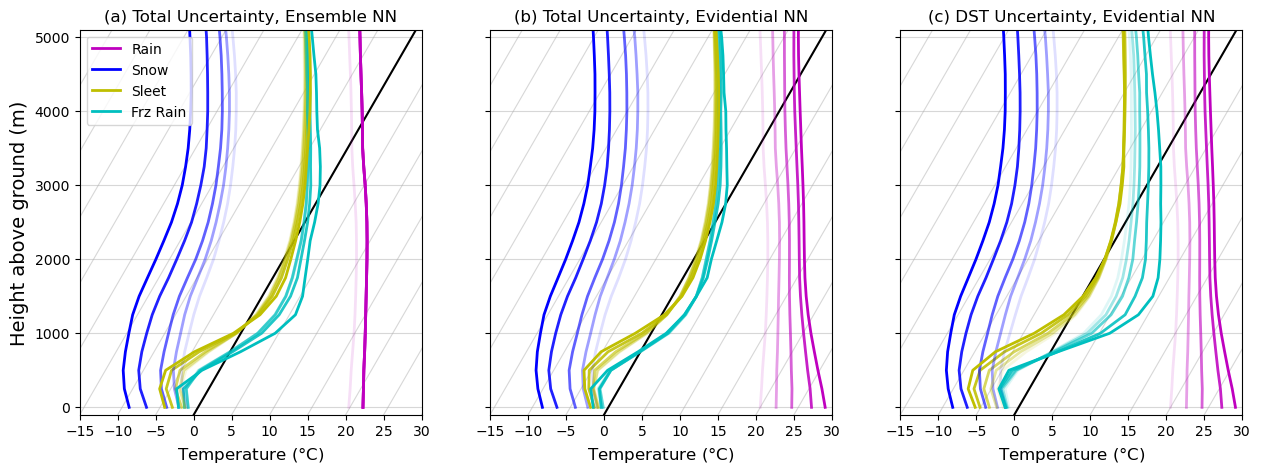

In [18]:
fig, axs = skewCompositeFigAx(figsize=(15, 5), num_subplots=3)
levels = list(np.arange(0.2,0.8,0.2)) + [0.1, 0.9]

fig, axs[0] = plot_many_uncerts(fig, axs[0], df_det, levels, True, uncert_type='total', profile_var='TEMP_C', title=f"(a) Total Uncertainty, Ensemble NN")
fig, axs[1] = plot_many_uncerts(fig, axs[1], df, levels, True, uncert_type='total', profile_var='TEMP_C', title=f"(b) Total Uncertainty, Evidential NN")
fig, axs[2] =  plot_many_uncerts(fig, axs[2], df, levels, True, uncert_type='evidential', profile_var='TEMP_C',title=f"(c) DST Uncertainty, Evidential NN")
axs[0].legend(fontsize=10)
for a in range(3):
    axs[a].set_xlabel("Temperature ($\\degree$C)", fontsize=12)
plt.savefig("figures/composite_soundings.pdf", dpi=300, bbox_inches="tight")

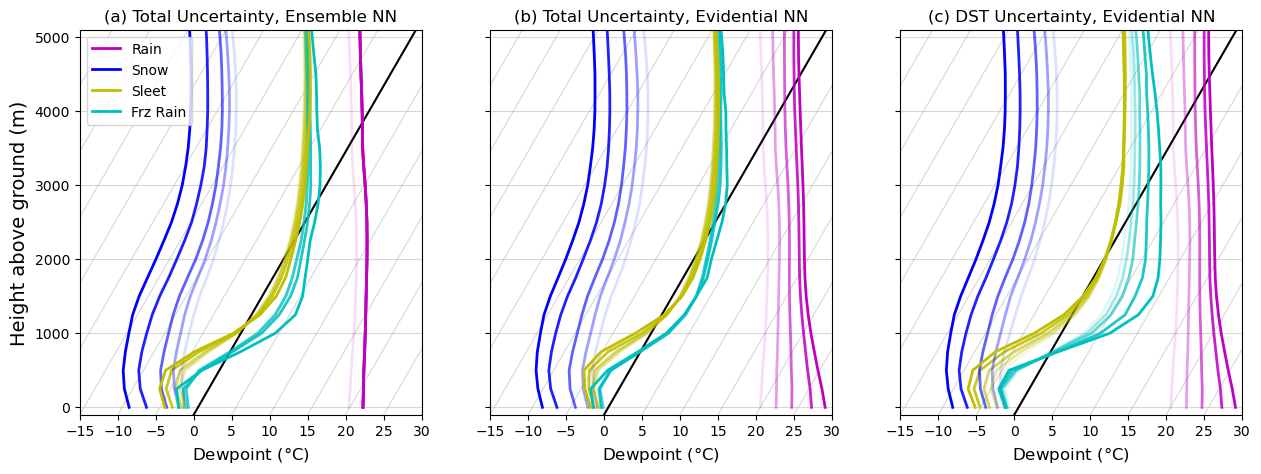

In [21]:
fig, axs = skewCompositeFigAx(figsize=(15, 5), num_subplots=3)
levels = list(np.arange(0.2,0.8,0.2)) + [0.1, 0.9]

fig, axs[0] = plot_many_uncerts(fig, axs[0], df_det, levels, True, uncert_type='total', profile_var='T_DEWPOINT_C', title=f"(a) Total Uncertainty, Ensemble NN")
fig, axs[1] = plot_many_uncerts(fig, axs[1], df, levels, True, uncert_type='total', profile_var='T_DEWPOINT_C', title=f"(b) Total Uncertainty, Evidential NN")
fig, axs[2] =  plot_many_uncerts(fig, axs[2], df, levels, True, uncert_type='evidential', profile_var='T_DEWPOINT_C',title=f"(c) DST Uncertainty, Evidential NN")
axs[0].legend(fontsize=10)
for a in range(3):
    axs[a].set_xlabel("Dewpoint ($\\degree$C)", fontsize=12)
plt.savefig("figures/composite_soundings_td.pdf", dpi=300, bbox_inches="tight")

In [20]:
df_det.columns

Index(['T_DEWPOINT_C_0_m', 'T_DEWPOINT_C_250_m', 'T_DEWPOINT_C_500_m',
       'T_DEWPOINT_C_750_m', 'T_DEWPOINT_C_1000_m', 'T_DEWPOINT_C_1250_m',
       'T_DEWPOINT_C_1500_m', 'T_DEWPOINT_C_1750_m', 'T_DEWPOINT_C_2000_m',
       'T_DEWPOINT_C_2250_m',
       ...
       'pred_conf3', 'pred_conf4', 'epistemic', 'entropy', 'mutual_info',
       'ave_conf', 'ave_entropy', 'ave_mutual_info', 'aleatoric', 'total'],
      dtype='object', length=468)

# Second Figure: sleet

In [17]:
#set color for sleet
color_dict[2] = '#FF7F0E'


## code

In [18]:
def plot_density(fig, ax, df, ptype, uncert_percentile, quantiles=np.array([0.1,0.2,0.3,0.4]), title='',
                 plot_below_percentile=True,
                 uncert_type=UNCERT_TYPE, profile_var=PROFILE_VAR, plot_kwargs={}):
    
    ax.set_xlabel(f'{profile_var}')
    subdf = df[(df.pred_label == ptype)]
    top_quantile = subdf[uncert_type].quantile(q=uncert_percentile)
    
    if plot_below_percentile:
        subdf = subdf[subdf[uncert_type] <= top_quantile]
    else:
        subdf = subdf[subdf[uncert_type] >= top_quantile]

    plot_data, data_cols = extract_cols(subdf)
    heights = [int(re.findall("(\d+)",txt)[0]) for txt in data_cols]
    
    profile = plot_data.median()
    (line,) = ax.plot(profile, heights, color_dict[ptype], linewidth=2, **plot_kwargs)
    
    q_vals = plot_data.quantile(np.concatenate((quantiles, 1-quantiles)))

    for q in quantiles:
        ax.fill_betweenx(heights, q_vals.loc[q], q_vals.loc[1-q], alpha=0.2, color=color_dict[ptype])
    

    line.set_label(
        (
            f'{ptype_dict[ptype]}'
        )
    )
    return fig, ax

def extract_cols_by_height(df, h_lim=3000, plot_cols='TEMP_C'):
    all_cols = list(df.columns)
    data_cols = []
    for col in all_cols:
        num = re.findall("(\d+)", col)
        if num: height = int(num[0])
        else: height = 1e6
        if (plot_cols in col) and (height <= h_lim): 
            data_cols.append(col)
    return df[data_cols], data_cols

def plot_actual_soundings(fig, ax, df, uncert_percentile, plot_below_percentile=True, 
                 ptypes = [2],
                 num_nearest=3, distances=[lambda x,y: np.sum((x-y)**2, axis=1),
                                          lambda x,y: np.sum(np.abs(x-y), axis=1)], 
                 uncert_type=UNCERT_TYPE, profile_var=PROFILE_VAR, plot_kwargs={}):
    df['idx'] = np.arange(0, df.shape[0])
    df = df.set_index('idx')
    for ptype in ptypes:
        subdf = df[(df.pred_label == ptype)]
        top_quantile = subdf[uncert_type].quantile(q=uncert_percentile)
        
        if plot_below_percentile:
            subdf = subdf[subdf[uncert_type] <= top_quantile]
        else:
            subdf = subdf[subdf[uncert_type] >= top_quantile]

        plot_data, data_cols = extract_cols(subdf)
        profile = plot_data.median()
        
        dist_data, dist_cols = extract_cols_by_height(subdf)
        plot_lines = find_nearest(profile[dist_cols], dist_data, num_nearest, distances)
        #plot_lines += find_furthest(profile[dist_cols], dist_data, num_nearest, distances)
        
        
        heights = [int(re.findall("(\d+)",txt)[0]) for txt in data_cols]
        #(line,) = ax.plot(profile, heights, color_dict[ptype], linewidth=2, **plot_kwargs)
        #line.set_label(f'{ptype_dict[ptype]}')
        
        for entry in plot_lines:
            ax.plot(plot_data.loc[entry], heights, color='#1F77B4', linewidth=1, linestyle='solid',
                    **plot_kwargs)
        
    ax.set_xlabel(f'{profile_var}')
    return fig,ax

def find_nearest(profile, plot_data, num_nearest, distances):
    nearest_ = []
    for dfunc in distances:
        dist = dfunc(profile, plot_data)
        for i in range(num_nearest):
            min_entry = dist.idxmin()
            nearest_.append(min_entry)
            dist = dist.drop(min_entry)
        
    return nearest_
def find_furthest(profile, plot_data, num_nearest, distances):
    nearest_ = []
    for dfunc in distances:
        dist = dfunc(profile, plot_data)
        for i in range(num_nearest):
            min_entry = dist.idxmax()
            nearest_.append(min_entry)
            dist = dist.drop(min_entry)
        
    return nearest_
    

## figure

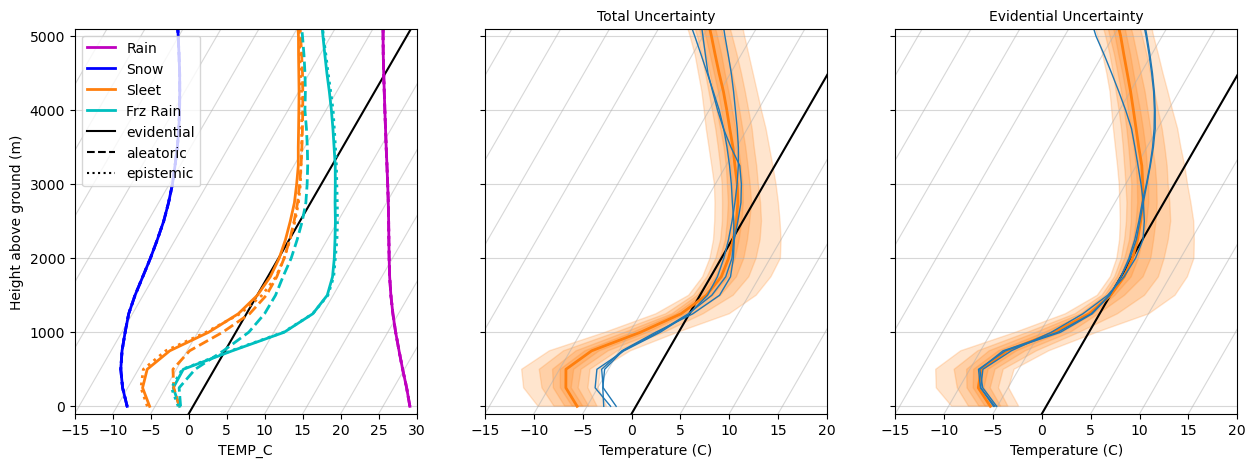

In [19]:
fig, axs = utils.skewCompositeFigAx(figsize=(15, 5), num_subplots=3)

##### uncertainty types together
ax = axs[0]
level = 0.1
linestyles = ['solid', 'dashed', 'dotted']
utypes = ['evidential', 'aleatoric', 'epistemic']
for uncert_type,lstyle in zip(utypes, linestyles):
    fig, ax = plot_(fig, ax, df, level, True, uncert_type=uncert_type, 
                     #title='',
                         plot_kwargs=dict(linestyle=lstyle))

for line in ax.lines:
    if (line.get_linestyle() != '-'):
        line.set_label('')
        
for uncert_type,lstyle in zip(utypes, linestyles):
    line, = ax.plot([], [], color='0', linestyle=lstyle)
    line.set_label(f'{uncert_type}')

ax.legend()

########## density plot ev uncert, then total uncert

fig, axs[2] = plot_density(fig, axs[2], df, 2, 0.1, uncert_type='evidential')
axs[2].set_title("Evidential Uncertainty",fontsize=10)


fig, axs[1] = plot_density(fig, axs[1], df, 2, 0.1)
axs[1].set_title("Total Uncertainty", fontsize=10)

plot_actual_soundings(fig, axs[2], df, 0.1, plot_below_percentile=True, 
                 num_nearest=3, distances=[lambda x,y: np.sum((x-y)**2, axis=1)],
            uncert_type='evidential')

plot_actual_soundings(fig, axs[1], df, 0.1, plot_below_percentile=True, 
                 num_nearest=3, distances=[lambda x,y: np.sum((x-y)**2, axis=1)],
            uncert_type='total')


### change xlims of sleet plots
for ax in axs[1:]:
    ax.set_xlim(-15,20)
    ax.set_xlabel("Temperature (C)", fontsize=10)